In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
plt.style.use('dark_background')
sys.path.append('../trim/transforms')
import dset_mnist as dset
from model_mnist import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
from scipy.special import softmax
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
im_torch, im_orig, label = dset.get_im_and_label(251, device=device) # this will download the mnist dataset
model = Net().to(device)
im_torch = im_torch.to(device)
model.load_state_dict(torch.load('mnist.model', map_location=device))
model = model.eval().to(device)

# get data
mnist = datasets.MNIST('mnist/data', train=True, download=True)
X = mnist.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
mnist_t = datasets.MNIST('mnist/data', train=False, download=True)
X_test = mnist_t.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)
Y_test = mnist_t.targets.numpy()

# fit/load nmf

In [12]:
nmf = NMF(n_components=30, random_state=42)
# nmf.fit(X)
# pkl.dump(nmf, open('nmf_30.pkl', 'wb'))
nmf = pkl.load(open('nmf_30.pkl', 'rb'))

In [13]:
# D = nmf.components_.reshape(-1, 28, 28)
# print('D.shape', D.shape)
# viz.viz_basis(D, save=True)

In [14]:
# # calc err
# X_t = nmf.transform(X) # (n, num_bases)
D = nmf.components_ # (num_bases, input_size)
# X_ = X_t @ D.astype(np.float32) # inverse transform
# print('err', np.mean(np.square(X_ - X)) / np.mean(np.square(X)))

# load model with transform

In [6]:
transform = transform_wrappers.lay_from_w(D)
norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
reshape = transform_wrappers.ReshapeLayer(shape=(1, 28, 28))
net = transform_wrappers.Net_with_transform(model, 
                                            transform=transform, 
                                            norm=norm, 
                                            reshape=reshape,
                                            use_logits=True).to(device)
# print(list(net.modules()))

# score and visualize nmf components

In [ ]:
def calc_scores(nmf, X, net):
    results = {
        'scores': [],
        'logits': [],
        'class_pred': []
    }
    for i in tqdm(range(10000)): # 10000 pts total
        x = X[i: i + 1]
        x_t = nmf.transform(x)
        x_t_tensor = torch.Tensor(x_t).to(device)

        pred = net(deepcopy(x_t_tensor)).cpu().detach().numpy()
        results['logits'].append(deepcopy(pred))
        results['class_pred'].append(np.argmax(pred))
        # x.requires_grad = False
        sweep_dim = 1
        tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
        cd_scores_im = acd.get_scores_2d(net, method='cd', ims=tiles, im_torch=x_t_tensor, device='cuda')
        results['scores'].append(deepcopy(cd_scores_im))

        if i == 100 or i % 1000 == 0:
            # 
            pkl.dump(results, open(f'nmf_scores_{i}.pkl', 'wb'))
# calc_scores(nmf, X, net)

In [15]:
# plot scores across bases
results = pkl.load(open(f'nmf_scores_{1000}.pkl', 'rb'))
# viz.plot_scores_across_bases(results)

In [16]:
scores_all = np.array(results['scores']) # (num points, 1, num_classes)
preds_all = np.array(results['logits']) # (num points, num_bases, num_classes)
# scores_all = softmax(scores_all, axis=-1)
titles = []
scores_all = np.mean(scores_all, axis=0)
titles = np.argmax(scores_all, axis=-1)
'''
for i in range(10):
    print(f'{i} {np.mean(scores_all[:, basis_num, i]):0.3f}')
    plt.hist(scores_all[:, basis_num, i], label=i, alpha=0.5)
#     plt.xscale('log')
plt.legend()
plt.show()
'''

"\nfor i in range(10):\n    print(f'{i} {np.mean(scores_all[:, basis_num, i]):0.3f}')\n    plt.hist(scores_all[:, basis_num, i], label=i, alpha=0.5)\n#     plt.xscale('log')\nplt.legend()\nplt.show()\n"

In [ ]:
D = nmf.components_.reshape(-1, 28, 28)
print('D.shape', D.shape)
viz.viz_basis(D, R=4, C=6, titles=titles)

# acd viz

In [42]:
results = {}
ex_num = 0
x = X_test[ex_num: ex_num + 1]
x_t = nmf.transform(x)
x_t_tensor = torch.Tensor(x_t).to(device)

y = Y_test[ex_num]
pred_class = net(deepcopy(x_t_tensor)).cpu().detach().numpy().argmax()

# x.requires_grad = False
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
cd_scores_im = acd.get_scores_2d(net, method='cd', ims=tiles, im_torch=x_t_tensor, device='cuda')[:, pred_class]


thresh = np.nanpercentile(cd_scores_im, q=75)
idxs_lowest = np.nonzero(cd_scores_im >= thresh)
print(y, pred_class, idxs_lowest)

7 7 (array([ 6,  8,  9, 10, 15, 17, 21, 26]),)


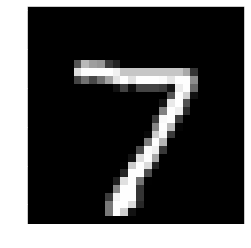

In [51]:
x = X_test[ex_num: ex_num + 1].reshape(28, 28)
plt.imshow(x, cmap='gray')
plt.show()

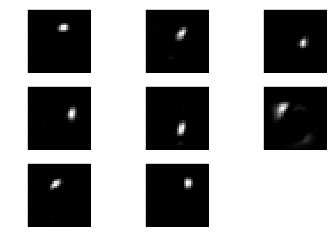

In [53]:
R, C = 3, 3
for i, idx in enumerate(idxs_lowest[0]):
    plt.subplot(R, C, i + 1)
    plt.imshow(nmf.components_[idx].reshape(28, 28), cmap='gray')